In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

#display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
#importing data from SQL
#https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'
                       .format(postgres_user, postgres_pw, postgres_host,
                              postgres_port, postgres_db))

df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

engine.dispose()

In [3]:
#display original 81 columns
df.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

In [4]:
df['yrsold'].unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [5]:
#df.info()

In [6]:
#one-hot encoding categorical variables and creating correlation matrix
one_hot = pd.get_dummies(df, drop_first=True)
corr_df = one_hot.corr()

#finding and dropping values that have less than 5% correlation in either direction with our target variable to shrink feature space
#low_corr = corr_df.loc[abs(corr_df['saleprice']) < .05]
#low_corr = low_corr['saleprice'].index
#low_corr_list = [x for x in low_corr]

df = one_hot#.drop(low_corr_list, axis=1)

In [7]:
#filling missing values
df['lotfrontage'].fillna(df['lotfrontage'].mean(), inplace=True)
df['garageyrblt'].fillna(df['yearbuilt'], inplace=True)
df['masvnrarea'].fillna(df['masvnrarea'].mean(), inplace=True)

#display number of null values
df.isnull().sum().sum()

0

In [8]:
#Performing PCA 
scaled_df = StandardScaler().fit_transform(df)
sklearn_pca = PCA(n_components=10)
pca_arrays  = sklearn_pca.fit_transform(scaled_df)

#checking how much variance is explained using PCA
sklearn_pca.explained_variance_ratio_.sum()

0.2289633669486182

We see that with 10 principle components we are only able to explain 33.9% of the variance. For this reason we will not be using PCA in our model. 

In [9]:
df['garagecars'].unique()

array([2, 3, 1, 0, 4], dtype=int64)

In [10]:
#df['garagearea'].unique()
#df['garageyrblt'].unique()
df['garagefinish_Unf'].unique()

array([0, 1], dtype=uint64)

In [11]:
#combining similar continuous features
df['garage'] = df['garagecars'] * df['garagearea'] * df['garageyrblt']
df['qual_liv_area'] = df['overallqual'] * df['grlivarea'] 
df['exter_kitchen_qual'] = df['exterqual_TA'] * df['kitchenqual_TA']

drop_list = ['garagecars', 'garagearea', 'garageyrblt', 'overallqual', 'grlivarea']
df = df.drop(drop_list, axis=1)

In [12]:
#finding 10 features that are most correlated with saleprice in either direction
top_10_abs = abs(df.corr()['saleprice']).sort_values(ascending=False)[1:11]
top_10_abs

qual_liv_area    0.832
garage           0.683
totalbsmtsf      0.614
firstflrsf       0.606
exterqual_TA     0.589
fullbath         0.561
totrmsabvgrd     0.534
yearbuilt        0.523
kitchenqual_TA   0.519
yearremodadd     0.507
Name: saleprice, dtype: float64

In [13]:
#saving names of features to list
pred_features = list(top_10_abs.index)

#Examining correlation between predictive features
top_10_abs_corr = df[top_10_abs.index].corr()
top_10_abs_corr

,qual_liv_area,garage,totalbsmtsf,firstflrsf,exterqual_TA,fullbath,totrmsabvgrd,yearbuilt,kitchenqual_TA,yearremodadd
qual_liv_area,1.000,0.604,0.556,0.596,-0.533,0.630,0.719,0.365,-0.466,0.411
garage,0.604,1.000,0.503,0.500,-0.494,0.444,0.392,0.491,-0.411,0.411
totalbsmtsf,0.556,0.503,1.000,0.820,-0.390,0.324,0.286,0.391,-0.311,0.291
firstflrsf,0.596,0.500,0.820,1.000,-0.313,0.381,0.410,0.282,-0.274,0.240
exterqual_TA,-0.533,-0.494,-0.390,-0.313,1.000,-0.466,-0.242,-0.589,0.672,-0.565
fullbath,0.630,0.444,0.324,0.381,-0.466,1.000,0.555,0.468,-0.419,0.439
totrmsabvgrd,0.719,0.392,0.286,0.410,-0.242,0.555,1.000,0.096,-0.210,0.192
yearbuilt,0.365,0.491,0.391,0.282,-0.589,0.468,0.096,1.000,-0.460,0.593
kitchenqual_TA,-0.466,-0.411,-0.311,-0.274,0.672,-0.419,-0.210,-0.460,1.000,-0.577
yearremodadd,0.411,0.411,0.291,0.240,-0.565,0.439,0.192,0.593,-0.577,1.000


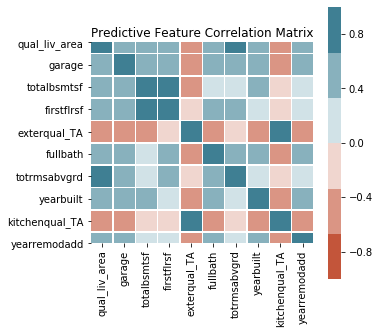

In [14]:
fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(
    top_10_abs_corr, 
    cmap=sns.diverging_palette(20, 220), 
    square=True,
    vmin=-1,
    vmax=1,
    linewidths=.5).set_title('Predictive Feature Correlation Matrix')

Based on the above correlation matrix we can see that we encounter a situation where we have three sets of features that have high correlation with eachother. We see that qual_liv_area and totrmsabvgrd, firstflrsf and totalbsmtsf, and exterqual_TA and kitchenqual_TA are all highly correlated (>67%). After itterating through the feature engineering step it is clear that by combining these features results in worse correlation with the target variable in each case. For this reason the lower of each pair will be dropped. 

In [15]:
#dropping less correlated of each of the highly correlated feature pairs and displaying remainder
pred_features = [x for x in pred_features if x not in ('totrmsabvgrd','firstflrsf', 'kitchenqual_TA')]
pred_features

['qual_liv_area',
 'garage',
 'totalbsmtsf',
 'exterqual_TA',
 'fullbath',
 'yearbuilt',
 'yearremodadd']

In [16]:
#define target variable
Y = df['saleprice']

#define predictive variables
X = df[pred_features]

#splitting data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=5)

# OLS Model

In [17]:
#adding constant
X_train = sm.add_constant(X_train)

#fitting linear regression model to data
OLS_model_train = sm.OLS(y_train, X_train).fit()

#printing summary statistics
OLS_model_train.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     548.6
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:00:21   Log-Likelihood:                -13973.
No. Observations:                1168   AIC:                         2.796e+04
Df Residuals:                    1160   BIC:                         2.800e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -1.19e+06   1.46e+05     -8.167      0.000   -1.48e+06   -9.04e+05
qual_liv_area     8.0825      0.345     23.445      0.000       7.406       8.759
garage            0.0104      0.001      9.810      0.000       0.008       0.012
totalbsmtsf      20.6455      3.224      6.404      0.000      14.320      26.971
exterqual_TA  -1.094e+04   3271.890     -3.344      0.001   -1.74e+04   -4522.859
fullbath      -3140.2082   2742.379     -1.145      0.252   -8520.786    2240.370
yearbuilt       303.4338     52.005      5.835      0.000     201.400     405.467
yearremodadd    334.6035     71.746      4.664      0.000     193.838     475.369
==============================================================================
Omnibus:                      922.473   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           152377.248
Skew:                          -2.782   Prob(JB):                         0.00
Kurtosis:                      58.678   Cond. No.                     3.17e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.17e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
#adding constant
X_test = sm.add_constant(X_test)

#fitting linear regression model to data
OLS_model_test = sm.OLS(y_test, X_test).fit()

#printing summary statistics
OLS_model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     347.6
Date:                Mon, 07 Oct 2019   Prob (F-statistic):          3.06e-135
Time:                        20:00:21   Log-Likelihood:                -3387.6
No. Observations:                 292   AIC:                             6791.
Df Residuals:                     284   BIC:                             6821.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.083e+06   2.15e+05     -5.042      0.000   -1.51e+06    -6.6e+05
qual_liv_area    12.3120      0.526     23.427      0.000      11.278      13.346
garage            0.0054      0.002      3.190      0.002       0.002       0.009
totalbsmtsf      35.3588      4.660      7.587      0.000      26.186      44.532
exterqual_TA   4650.3844   4551.573      1.022      0.308   -4308.714    1.36e+04
fullbath      -1.402e+04   4380.462     -3.201      0.002   -2.26e+04   -5401.572
yearbuilt       358.1435     87.412      4.097      0.000     186.086     530.201
yearremodadd    206.7091    106.741      1.937      0.054      -3.395     416.814
==============================================================================
Omnibus:                       21.062   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.429
Skew:                           0.272   Prob(JB):                     1.52e-12
Kurtosis:                       5.044   Cond. No.                     3.17e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.17e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

When we testing this model on the traning data we found an adjusted R-squared value of .836, additionally we saw that all of our parameters were statistically significant by examining their p-values, which were all less than 0.05. However when we test this model on the testing data we can see a significant drop in performance. We see that our adjust R-squared drops to .644. This is an indication that our model is overfit. We can also see that on the testing data we have p-values that exceed our 0.10 threshold. This can be seen for the totalbsmtsf and fullbath features which both are now statistically insignificant. To improve this model we could drop these features and reexamine our test statistics.

# Lasso Regression Model

In [19]:
lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)


print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 77829569.39578474
R-squared of the model in training set is: 0.6653398111968482
-----Test set statistics-----
R-squared of the model in test set is: 0.705311577986093
Mean absolute error of the prediction is: 28048.702060267216
Mean squared error of the prediction is: 1969866281.5180519
Root mean squared error of the prediction is: 44383.1756583286
Mean absolute percentage error of the prediction is: 17.57066270693426


# Ridge Regression Model

In [20]:
ridge_cv = RidgeCV(cv=10)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)


print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.7679949406015176
-----Test set statistics-----
R-squared of the model in test set is: 0.8527319118030798
Mean absolute error of the prediction is: 20171.77944646849
Mean squared error of the prediction is: 984424292.275213
Root mean squared error of the prediction is: 31375.53652569487
Mean absolute percentage error of the prediction is: 11.973080746655134


# ElasticNet Regression Model

In [21]:
elasticnet_cv = ElasticNetCV(cv=10)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 155659138.79156917
R-squared of the model in training set is: 0.515102734434085
-----Test set statistics-----
R-squared of the model in test set is: 0.514281801193931
Mean absolute error of the prediction is: 35871.7017885568
Mean squared error of the prediction is: 3246818777.639672
Root mean squared error of the prediction is: 56980.86325811212
Mean absolute percentage error of the prediction is: 22.31794847982364


# Dropping features and retesting models

In [22]:
#dropping features that were not statistically significant in test set
pred_features = [x for x in pred_features if x not in ('totalbsmtsf','fullbath')]

#define target variable
Y = df['saleprice']

#define predictive variables
X = df[pred_features]

#splitting data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

# OLS Model V2

In [23]:
#adding constant
X_train = sm.add_constant(X_train)

#fitting linear regression model to data
OLS_model_train = sm.OLS(y_train, X_train).fit()

#printing summary statistics
OLS_model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     758.2
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:00:21   Log-Likelihood:                -13999.
No. Observations:                1168   AIC:                         2.801e+04
Df Residuals:                    1162   BIC:                         2.804e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.169e+06   1.44e+05     -8.140      0.000   -1.45e+06   -8.87e+05
qual_liv_area     9.0720      0.300     30.271      0.000       8.484       9.660
garage            0.0110      0.001     10.332      0.000       0.009       0.013
exterqual_TA  -9944.5973   3334.207     -2.983      0.003   -1.65e+04   -3402.857
yearbuilt       333.5311     51.878      6.429      0.000     231.745     435.317
yearremodadd    297.2903     72.936      4.076      0.000     154.188     440.392
==============================================================================
Omnibus:                      681.545   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75003.034
Skew:                          -1.742   Prob(JB):                         0.00
Kurtosis:                      42.103   Cond. No.                     3.09e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#adding constant
X_test = sm.add_constant(X_test)

#fitting linear regression model to data
OLS_model_test = sm.OLS(y_test, X_test).fit()

#printing summary statistics
OLS_model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     274.5
Date:                Mon, 07 Oct 2019   Prob (F-statistic):          6.90e-107
Time:                        20:00:21   Log-Likelihood:                -3441.0
No. Observations:                 292   AIC:                             6894.
Df Residuals:                     286   BIC:                             6916.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.074e+06   2.49e+05     -4.315      0.000   -1.56e+06   -5.84e+05
qual_liv_area    10.2535      0.461     22.221      0.000       9.345      11.162
garage            0.0113      0.002      5.667      0.000       0.007       0.015
exterqual_TA  -1291.9348   5451.167     -0.237      0.813    -1.2e+04    9437.561
yearbuilt       436.2205     90.579      4.816      0.000     257.935     614.506
yearremodadd    137.0475    123.909      1.106      0.270    -106.841     380.936
==============================================================================
Omnibus:                       67.504   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              318.966
Skew:                           0.851   Prob(JB):                     5.46e-70
Kurtosis:                       7.829   Cond. No.                     2.97e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.97e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Lasso Regression V2

In [25]:
lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)


print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 81029526.33611512
R-squared of the model in training set is: 0.6707167118221848
-----Test set statistics-----
R-squared of the model in test set is: 0.6950199706482358
Mean absolute error of the prediction is: 27741.191217411088
Mean squared error of the prediction is: 1782027329.8441577
Root mean squared error of the prediction is: 42214.06554507819
Mean absolute percentage error of the prediction is: 17.167698903572383


# Ridge Regression V2

In [26]:
ridge_cv = RidgeCV(cv=10)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)


print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.7653916422307315
-----Test set statistics-----
R-squared of the model in test set is: 0.8186301956126757
Mean absolute error of the prediction is: 22194.04589234656
Mean squared error of the prediction is: 1059761024.0699233
Root mean squared error of the prediction is: 32553.97094165201
Mean absolute percentage error of the prediction is: 12.989637494419009


# ElasticNet Regression V2

In [27]:
elasticnet_cv = ElasticNetCV(cv=10)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 162059052.67223057
R-squared of the model in training set is: 0.5180067475009595
-----Test set statistics-----
R-squared of the model in test set is: 0.484835458376881
Mean absolute error of the prediction is: 35550.965427010306
Mean squared error of the prediction is: 3010155433.7519298
Root mean squared error of the prediction is: 54864.883429675945
Mean absolute percentage error of the prediction is: 21.97811730684306


# Additional Data

In [28]:
zillow_df = pd.read_csv('State_time_series.csv')

In [29]:
zillow_df.shape

(13212, 82)

In [30]:
#brining in additional data for Iowa in the time span that we were examining 
zillow_df = zillow_df.loc[zillow_df['RegionName'] == 'Iowa']

zillow_df['Date'] = pd.to_datetime(zillow_df['Date'])
zillow_data = zillow_df.loc[(zillow_df['Date'] >= '2006-01-01') & (zillow_df['Date'] <= '2010-01-01')]
zillow_data = zillow_data[['Date', 'PctOfHomesDecreasingInValues_AllHomes', 'PctOfHomesIncreasingInValues_AllHomes']]

In [31]:
#adding a column of values calculated from mean of mean of state home value increase + decrease by month
unique_yr = df['yrsold'].unique()

increase = []
decrease = []

for year in unique_yr:
    year_start = zillow_data['Date'] >= pd.to_datetime(str(year-1)+'-12-31')
    year_end = zillow_data['Date'] <= pd.to_datetime(str(year)+'-12-31')
    means = zillow_data.loc[(year_start) & (year_end)].mean()
    df.loc[df['yrsold'] == year, 'PctHomesIncValue'] = means[0]
    df.loc[df['yrsold'] == year, 'PctHomesDecValue'] = means[1]



In [32]:
df[['PctHomesIncValue', 'PctHomesDecValue']].head()

,PctHomesIncValue,PctHomesDecValue
0,43.518,43.525
1,38.203,48.202
2,43.518,43.525
3,30.838,57.300
4,43.518,43.525


# Adding additional features

In [34]:
#adding features from zillow dataset
pred_features.append('PctHomesIncValue')
pred_features.append('PctHomesDecValue')

#define target variable
Y = df['saleprice']

#define predictive variables
X = df[pred_features]

#splitting data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

# OLS Model V3

In [36]:
#adding constant
X_train = sm.add_constant(X_train)

#fitting linear regression model to data
OLS_model_train = sm.OLS(y_train, X_train).fit()

#printing summary statistics
OLS_model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     632.8
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:00:46   Log-Likelihood:                -13926.
No. Observations:                1168   AIC:                         2.787e+04
Df Residuals:                    1160   BIC:                         2.791e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.115e+06   1.49e+05     -7.498      0.000   -1.41e+06   -8.23e+05
qual_liv_area        9.9505      0.280     35.587      0.000       9.402      10.499
garage               0.0099      0.001      9.565      0.000       0.008       0.012
exterqual_TA     -6234.0423   3136.516     -1.988      0.047   -1.24e+04     -80.162
yearbuilt          376.6849     49.751      7.571      0.000     279.074     474.296
yearremodadd       219.5094     70.006      3.136      0.002      82.157     356.861
PctHomesIncValue   -63.4290    741.377     -0.086      0.932   -1518.019    1391.161
PctHomesDecValue   167.9176    626.172      0.268      0.789   -1060.640    1396.475
==============================================================================
Omnibus:                      678.106   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           109244.697
Skew:                          -1.621   Prob(JB):                         0.00
Kurtosis:                      50.268   Cond. No.                     3.34e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
#adding constant
X_test = sm.add_constant(X_test)

#fitting linear regression model to data
OLS_model_test = sm.OLS(y_test, X_test).fit()

#printing summary statistics
OLS_model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     105.8
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.51e-75
Time:                        20:01:03   Log-Likelihood:                -3511.0
No. Observations:                 292   AIC:                             7038.
Df Residuals:                     284   BIC:                             7067.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.164e+06   3.25e+05     -3.585      0.000    -1.8e+06   -5.25e+05
qual_liv_area        6.9663      0.617     11.294      0.000       5.752       8.180
garage               0.0153      0.002      6.897      0.000       0.011       0.020
exterqual_TA     -1.618e+04   6968.967     -2.322      0.021   -2.99e+04   -2463.676
yearbuilt          223.3139    109.139      2.046      0.042       8.490     438.138
yearremodadd       457.3761    149.228      3.065      0.002     163.642     751.110
PctHomesIncValue -1064.7021   1662.299     -0.640      0.522   -4336.691    2207.287
PctHomesDecValue -1013.2538   1396.628     -0.725      0.469   -3762.310    1735.803
==============================================================================
Omnibus:                      141.179   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3592.895
Skew:                          -1.374   Prob(JB):                         0.00
Kurtosis:                      19.963   Cond. No.                     3.26e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Lasso Regression V3

In [39]:
lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)


print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 77457629.65233849
R-squared of the model in training set is: 0.7065794063350719
-----Test set statistics-----
R-squared of the model in test set is: 0.6638150071714788
Mean absolute error of the prediction is: 29520.83013555863
Mean squared error of the prediction is: 1972914854.558256
Root mean squared error of the prediction is: 44417.50617220935
Mean absolute percentage error of the prediction is: 18.766162266983567


# Ridge Regression V3

In [38]:
ridge_cv = RidgeCV(cv=10)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)


print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.7924651359912909
-----Test set statistics-----
R-squared of the model in test set is: 0.6972222093268282
Mean absolute error of the prediction is: 25815.990662347616
Mean squared error of the prediction is: 1776863374.6067455
Root mean squared error of the prediction is: 42152.85725317734
Mean absolute percentage error of the prediction is: 15.50629833401214


# ElasticNet Regression V3

In [40]:
elasticnet_cv = ElasticNetCV(cv=10)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 154915259.30467668
R-squared of the model in training set is: 0.5227179407351656
-----Test set statistics-----
R-squared of the model in test set is: 0.5193926400650948
Mean absolute error of the prediction is: 37110.096767087045
Mean squared error of the prediction is: 2820463196.9079313
Root mean squared error of the prediction is: 53108.033261531455
Mean absolute percentage error of the prediction is: 23.867680511816072


Adding additional data from our second dataset did not improve our prediction accuracy. When the model including these new features was tested it was found that these new features were not statistically significant. It is possible that the method in which they were implimented was over simplified. In this case I used mean values calculated from the values reported by the month and assigned them to the original dataframe according to the year in which the house was sold. It is possible that we could have improved prediction if this model is fixed to have the monthly values assigned to the dataframe based on the month the house was sold instead of using the mean value for the year. 